<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/FastAIDRGrading_ensemble_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# !pip install fastai==1.0.42

In [101]:
# Set seed for all
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [102]:
import os
 
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
 
from sklearn.model_selection import train_test_split
 
from PIL import Image
 
pd.set_option('display.max_colwidth',1000) # to avoid output truncation

In [103]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [104]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


#Train Data Read

In [105]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
 
df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['path'] = dataset_images_location + '/' + df['Image name'] + ".jpg"
df_['level'] = df['Retinopathy grade']
df = df_
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
#df['level'] = df['level'].astype('int32')
# df.head(10)
print(df)
 
img = cv2.imread(df['path'][1])
print(img.dtype)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_035.jpg      3
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_340.jpg      2
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_260.jpg      2
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_231.jpg      2
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_121.jpg      2
..                                                                                                 ...    ...
408  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_138.jpg      0
409  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_199.jpg      0
410  /cont

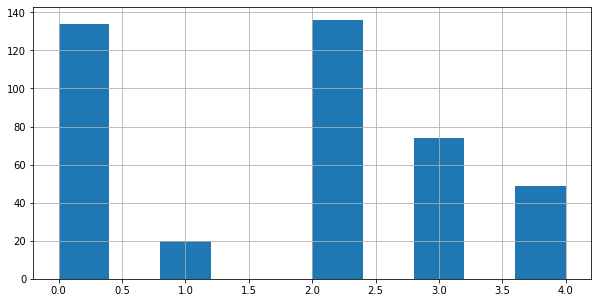

In [106]:
df['level'].hist(figsize = (10, 5))

In [107]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,134
1,20
2,136
3,74
4,49


In [108]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [109]:
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

83

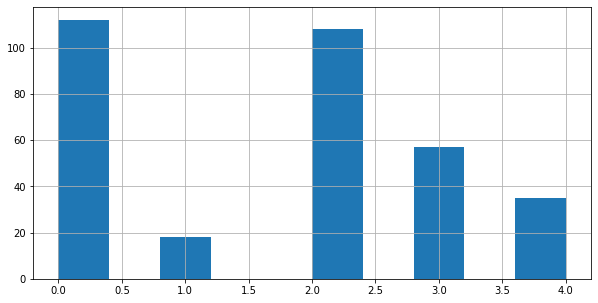

In [110]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [111]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,112
1,18
2,108
3,57
4,35


New Data Size: 560 Old Size: 330


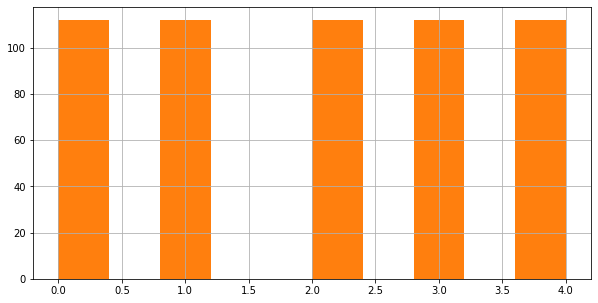

In [112]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [113]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)
print(df)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_402.jpg      1
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_282.jpg      2
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_357.jpg      3
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_302.jpg      1
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_293.jpg      2
..                                                                                                 ...    ...
329  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_140.jpg      0
239  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_026.jpg      3
389  /cont

In [114]:
im = Image.open(train_df['path'][1])
width, height = im.size
# im.show
# print(width,height)

In [115]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224
print(len(train_df))
print(len(val_df))
print(len(df))

560
83
643


In [116]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [117]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
 
data = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz, valid_pct = (len(val_df) / len(df)), bs = bs)
data = data.normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,3,1,2,1
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,0,4,4,2
Path: /;

Test: None


[0, 1, 2, 3, 4]


(5, 5)

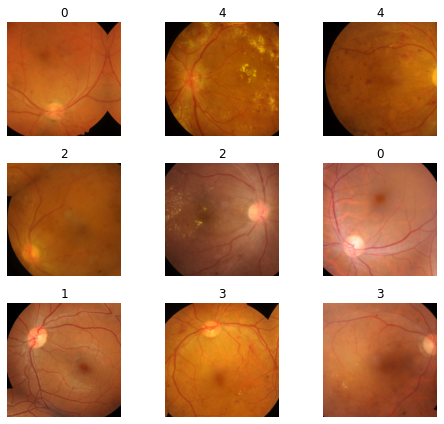

In [118]:
data.show_batch(rows=3, figsize=(7,6))

print(data.classes)
len(data.classes),data.c

#Transfer Learning (Resnet50 and Densenet121)

In [119]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

In [120]:
import torchvision
learn_resnet = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])
learn_densenet = create_cnn(data, models.densenet121, metrics = [accuracy,quadratic_kappa])
# learn = Learner(data, models.EfficientNetB1, metrics = [accuracy,quadratic_kappa])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [121]:
# learn_resnet.lr_find()

In [122]:
# learn_resnet.recorder.plot(suggestion=True)

In [123]:
# learn_densenet.lr_find()

In [124]:
# learn_densenet.recorder.plot(suggestion=True)

In [125]:
learn_resnet.fit_one_cycle(4,max_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,2.228842,1.095068,0.542169,0.779548,03:51
1,1.838145,1.281681,0.662651,0.820562,03:41
2,1.503322,0.941122,0.710843,0.827003,03:46
3,1.333856,0.971354,0.686747,0.851414,03:43


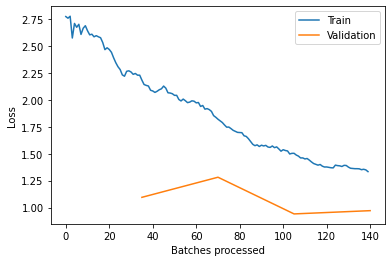

In [126]:
learn_resnet.recorder.plot_losses()

In [127]:
learn_resnet.save('stage-1-224')
# see how to load the model

In [128]:
learn_resnet.unfreeze()

In [129]:
# learn_resnet.lr_find()

In [130]:
# learn_resnet.recorder.plot()

In [131]:
learn_resnet.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.028096,0.948237,0.710843,0.848917,03:40
1,1.021102,0.908394,0.746988,0.872940,03:33
2,0.963982,0.840627,0.746988,0.869445,03:40
3,0.945890,0.866893,0.759036,0.894812,03:32


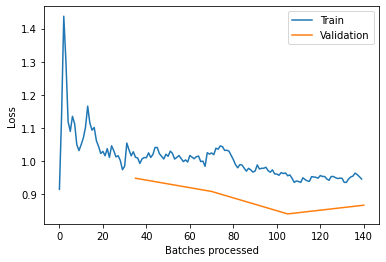

In [132]:
learn_resnet.recorder.plot_losses()

In [133]:
learn_resnet.save('stage-2-224')

In [134]:
learn_densenet.fit_one_cycle(4,max_lr = 1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,2.022229,1.084180,0.578313,0.787683,03:35
1,1.738708,0.802302,0.722892,0.838602,03:33
2,1.474160,0.710473,0.710843,0.842739,03:41
3,1.284896,0.644934,0.734940,0.831292,03:41


In [135]:
learn_densenet.unfreeze()

In [136]:
learn_densenet.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.051814,0.616360,0.734940,0.830160,03:48
1,1.001929,0.592806,0.795181,0.877976,03:44
2,1.010457,0.554875,0.807229,0.880030,03:44
3,0.981674,0.551562,0.807229,0.872052,03:46


#Progressive Resizing

In [137]:
dataNew = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz * 2, valid_pct = (len(val_df) / len(df)), bs = 4)
dataNew = dataNew.normalize(imagenet_stats)

In [138]:
learn_resnet.data = dataNew
learn_densenet.data = dataNew
dataNew.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [139]:
learn_resnet.freeze()
learn_densenet.freeze()

In [140]:
# learn_resnet.lr_find()
# learn_resnet.recorder.plot()

In [141]:
learn_resnet.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.763296,1.050218,0.626506,0.727216,04:23
1,1.773257,0.845014,0.710843,0.839904,04:20
2,1.422499,0.679467,0.734940,0.830745,04:17
3,1.387928,0.668836,0.698795,0.809203,04:16


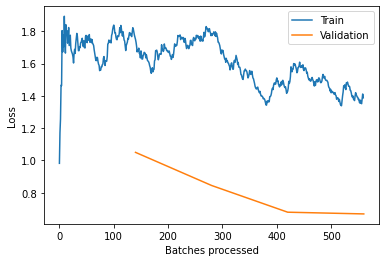

In [142]:
learn_resnet.recorder.plot_losses()

In [143]:
learn_resnet.save('stage-1-448')

In [144]:
learn_resnet.unfreeze()

In [145]:
# learn_resnet.lr_find()
# learn_resnet.recorder.plot()

In [146]:
learn_resnet.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.171237,0.657848,0.722892,0.761373,04:21
1,1.127765,0.616648,0.795181,0.869510,04:22
2,1.173629,0.589867,0.771084,0.809250,04:22
3,1.072402,0.585262,0.831325,0.881768,04:23


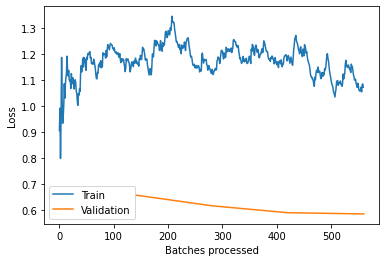

In [147]:
learn_resnet.recorder.plot_losses()

In [148]:
learn_resnet.save('stage-2-448')

In [149]:
learn_densenet.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.705744,1.595839,0.530120,0.578586,04:19
1,1.630804,0.932194,0.650602,0.697314,04:16
2,1.489815,0.890764,0.638554,0.640744,04:14
3,1.386085,0.785019,0.734940,0.813159,04:14


In [150]:
learn_densenet.unfreeze()

In [151]:
learn_densenet.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.430600,0.765253,0.686747,0.730993,04:23
1,1.360262,0.727364,0.783133,0.751309,04:24
2,1.336129,0.759195,0.734940,0.725362,04:22
3,1.280482,0.698728,0.722892,0.755077,04:21


#Checking Results

In [152]:
interp = ClassificationInterpretation.from_learner(learn_resnet)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

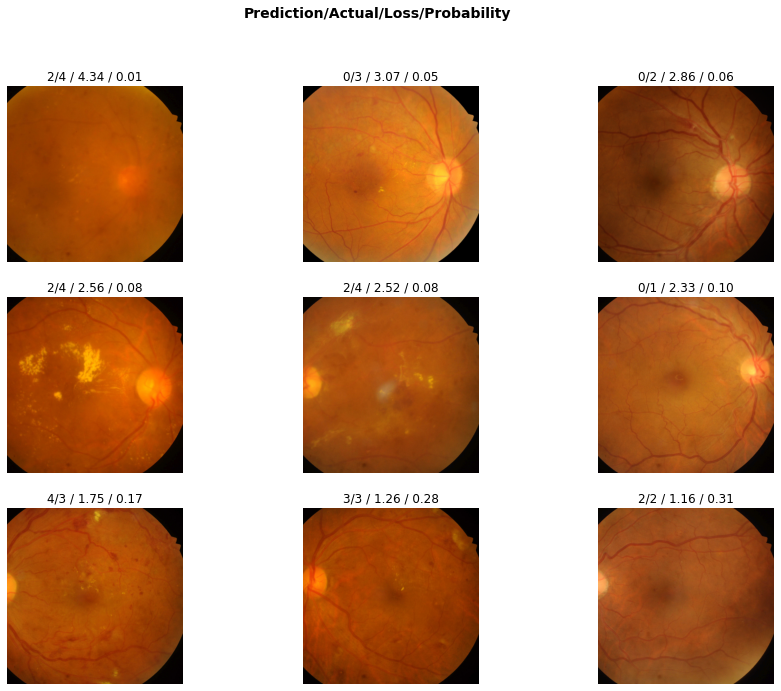

In [153]:
interp.plot_top_losses(9, figsize=(15,11))

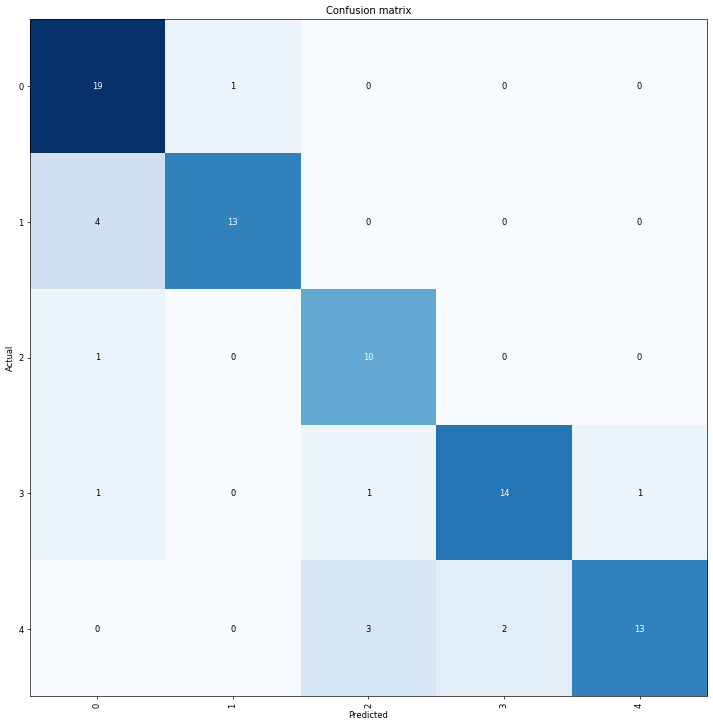

In [154]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Testing Data

In [155]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['path'] = test_images_location + '/' + test_df['Image name'] + ".jpg"
test_df_['level'] = test_df['Retinopathy grade']
test_df = test_df_

print(test_df)

                                                                                                 path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_001.jpg      4
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_002.jpg      4
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_003.jpg      4
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_004.jpg      4
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_005.jpg      4
..                                                                                                ...    ...
98   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_099.jpg      0
99   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_100.jpg      2
100  /content/drive

In [156]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='/', df=test_df))
learn_resnet.data.add_test(test)
learn_densenet.data.add_test(test)

In [157]:
# Get predictions
preds1, l1 = learn_resnet.get_preds(DatasetType.Test)
preds2, l2 = learn_resnet.TTA(ds_type=DatasetType.Test)

preds_densenet, l3 = learn_densenet.get_preds(DatasetType.Test)

In [158]:
preds1

tensor([[2.4138e-03, 5.4510e-04, 1.5430e-01, 2.4430e-01, 5.9843e-01],
        [5.4542e-01, 1.4776e-02, 2.8407e-01, 2.3407e-02, 1.3233e-01],
        [3.0051e-01, 2.3351e-01, 1.8687e-01, 2.1285e-02, 2.5783e-01],
        [6.8741e-01, 2.2702e-01, 6.1721e-03, 1.3805e-02, 6.5592e-02],
        [1.2207e-01, 2.9021e-03, 7.6352e-01, 7.7772e-02, 3.3737e-02],
        [1.4608e-01, 5.9014e-03, 8.5993e-02, 6.7910e-01, 8.2929e-02],
        [1.0207e-02, 3.0999e-02, 1.1932e-01, 5.5567e-01, 2.8381e-01],
        [1.8542e-01, 2.5362e-02, 6.5356e-01, 1.3401e-01, 1.6477e-03],
        [3.7618e-03, 1.4103e-03, 9.5650e-01, 2.2337e-02, 1.5986e-02],
        [3.8937e-01, 2.0029e-02, 5.3285e-01, 3.9439e-02, 1.8320e-02],
        [7.7156e-03, 1.1346e-04, 9.5452e-01, 3.4104e-02, 3.5439e-03],
        [8.8823e-02, 8.8397e-01, 2.2763e-02, 3.8386e-03, 6.0860e-04],
        [7.6151e-03, 6.1543e-04, 2.4282e-02, 8.9374e-01, 7.3747e-02],
        [1.2811e-03, 1.1177e-03, 4.4199e-02, 9.1830e-01, 3.5100e-02],
        [5.5443e-03,

In [159]:
preds2

tensor([[1.7565e-03, 7.2668e-04, 1.3768e-01, 1.5579e-01, 7.0405e-01],
        [2.5619e-01, 5.1120e-02, 2.7672e-01, 9.8409e-02, 3.1756e-01],
        [2.1039e-01, 2.9219e-01, 2.3647e-01, 2.1107e-02, 2.3985e-01],
        [3.5819e-01, 2.1638e-01, 3.1184e-02, 1.3089e-02, 3.8115e-01],
        [6.4118e-02, 1.9455e-02, 4.3938e-01, 3.3495e-02, 4.4355e-01],
        [1.5524e-01, 6.5972e-02, 6.1406e-02, 3.8123e-01, 3.3615e-01],
        [6.5513e-03, 7.3367e-02, 1.7219e-01, 3.8556e-01, 3.6233e-01],
        [1.1809e-01, 1.7815e-01, 5.1000e-01, 1.4049e-01, 5.3265e-02],
        [7.4394e-03, 1.7715e-02, 8.6935e-01, 6.0791e-02, 4.4709e-02],
        [1.7795e-01, 1.9214e-02, 5.8686e-01, 3.0162e-02, 1.8582e-01],
        [7.1850e-02, 4.9476e-03, 8.5821e-01, 2.3779e-02, 4.1214e-02],
        [1.4258e-01, 7.0721e-01, 9.4719e-02, 2.9374e-02, 2.6118e-02],
        [6.1934e-03, 2.7501e-02, 1.0979e-01, 7.2532e-01, 1.3119e-01],
        [3.4275e-03, 1.0978e-02, 1.3622e-01, 7.1478e-01, 1.3459e-01],
        [4.3511e-03,

In [160]:
preds_densenet

tensor([[3.1051e-04, 2.9099e-05, 2.0743e-03, 2.1513e-02, 9.7607e-01],
        [3.4768e-02, 1.2825e-02, 8.0538e-01, 1.1958e-02, 1.3507e-01],
        [8.5074e-02, 1.2812e-02, 2.4634e-01, 1.5604e-01, 4.9974e-01],
        [9.5647e-02, 2.5714e-01, 7.8434e-02, 2.9811e-01, 2.7067e-01],
        [4.0844e-01, 6.1402e-03, 1.9696e-01, 5.2990e-03, 3.8316e-01],
        [6.2567e-02, 2.2156e-02, 3.2547e-01, 5.2719e-01, 6.2620e-02],
        [1.1836e-02, 3.9693e-02, 1.2861e-01, 3.9787e-01, 4.2199e-01],
        [1.1286e-02, 2.0131e-02, 1.2414e-01, 8.1719e-01, 2.7252e-02],
        [8.9872e-04, 9.7729e-04, 6.2756e-01, 2.3035e-02, 3.4753e-01],
        [1.5070e-01, 4.1386e-02, 5.0216e-01, 1.6749e-01, 1.3827e-01],
        [3.9904e-01, 2.9187e-03, 5.8410e-01, 1.0812e-02, 3.1320e-03],
        [2.6179e-01, 7.1563e-01, 9.1555e-03, 7.4041e-03, 6.0202e-03],
        [6.4006e-04, 3.1393e-03, 2.5045e-01, 7.1166e-01, 3.4109e-02],
        [5.2360e-04, 3.1385e-03, 2.9142e-01, 3.7168e-01, 3.3324e-01],
        [2.4591e-04,

In [161]:
preds1 = np.array(preds1)
preds2 = np.array(preds2)
preds_densenet = np.array(preds_densenet)
preds_ensenmble = preds1 + preds_densenet
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103, 5)
preds2 (103, 5)


In [162]:
preds1 = np.argmax(preds1, axis = 1)
preds2 = np.argmax(preds2, axis = 1)
preds_densenet = np.argmax(preds_densenet, axis = 1)
preds_ensenmble = np.argmax(preds_ensenmble, axis = 1)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103,)
preds2 (103,)


In [163]:
labels = test_df['level']
labels.shape

(103,)

In [164]:
preds1

array([4, 0, 0, 0, ..., 2, 2, 2, 0])

In [165]:
preds2

array([4, 4, 1, 4, ..., 2, 2, 2, 0])

In [166]:
from sklearn.metrics import accuracy_score
print("preds1 => accuracy:", accuracy_score(labels, preds1))
print("preds2(with TTA) => accuracy:", accuracy_score(labels, preds2))
print("preds_densenet => accuracy:", accuracy_score(labels, preds_densenet))
print("preds_ensemble => accuracy:", accuracy_score(labels, preds_ensenmble))

preds1 => accuracy: 0.5631067961165048
preds2(with TTA) => accuracy: 0.5242718446601942
preds_densenet => accuracy: 0.5242718446601942
preds_ensemble => accuracy: 0.6019417475728155


In [168]:
from sklearn.metrics import cohen_kappa_score
print("preds1 => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds1, weights = "quadratic"));
print("preds2(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds2, weights = "quadratic"));
print("preds_densenet => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_densenet, weights = "quadratic"));
print("preds_ensemble => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds_ensenmble, weights = "quadratic"));

preds1 => quadratic_weighted_kappa: 0.5826515601207836
preds2(with TTA) => quadratic_weighted_kappa: 0.6713429058700555
preds_densenet => quadratic_weighted_kappa: 0.6482822847682119
preds_ensemble => quadratic_weighted_kappa: 0.6960119062634009


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds1) 
print("preds1 => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

In [ ]:
cm = confusion_matrix(labels, preds2) 
print("preds2(with TTA) => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

In [ ]:
# TTA is easy - use .TTA() in place of .get_preds()
# preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
# acc_tta = accuracy(preds_tta, labels_tta)
# print(acc_tta)

In [ ]:
# test_images = []
# im_size = 224
# for image_path in df['path']:
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (im_size, im_size));
#     test_images.append(img);

In [ ]:
# test_pred = learn.predict_array(test_imgs)
# test_pred = np.argmax(test_pred, axis=1)
# test_pred

In [ ]:
# sample for finding quadratic weighted kappa
# from sklearn.metrics import cohen_kappa_score, confusion_matrix
# import numpy as np
# from time import time

# #dataset
# actuals = np.array([4, 4, 3, 4, 4, 0, 1, 1, 2, 1])
# preds   = np.array([0, 4, 1, 0, 4, 0, 1, 1, 2, 1])
# qwk = cohen_kappa_score(actuals, preds, weights="quadratic")
# print(qwk)